In [1]:
import uuid
import random
import pygad
import numpy as np
import seaborn as sns
sns.set()
random.seed(42)

In [2]:
class Room:
    def __init__(self, name, width, height, pixels):
        self.name = name
        self.width = width
        self.height = height
        self.pixels = pixels

    def __str__(self):
        room_str = ""
        for row in self.pixels:
            room_str += "".join(row) + "\n"
        return room_str

# Example usage
a = Room("A", 6, 6, [
    [' #', ' #', ' #', ' #', ' #', ' #'],
    [' #', ' +', ' +', ' +', ' +', ' #'],
    [' #', ' +', ' A', ' A', ' +', ' #'],
    [' #', ' +', ' A', ' A', ' +', ' #'],
    [' #', ' +', ' +', ' +', ' +', ' #'],
    [' #', ' #', ' #', ' #', ' #', ' #']
])

b = Room("B", 4, 6, [
    [' #', ' #', ' #', ' #'],
    [' #', ' +', ' +', ' #'],
    [' #', ' B', ' B', ' #'],
    [' #', ' B', ' B', ' #'],
    [' #', ' +', ' +', ' #'],
    [' #', ' #', ' #', ' #']
])

c = Room("C", 6, 4, [
    [' #', ' #', ' #', ' #', ' #', ' #'],
    [' #', ' +', ' C', ' C', ' +', ' #'],
    [' #', ' +', ' C', ' C', ' +', ' #'],
    [' #', ' #', ' #', ' #', ' #', ' #']
])

d = Room("D", 4, 4, [
    [' #', ' #', ' #', ' #'],
    [' #', ' D', ' D', ' #'],
    [' #', ' D', ' D', ' #'],
    [' #', ' #', ' #', ' #']
])

room_map = {
    0: a,
    1: b,
    2: c,
    3: d
}


In [3]:
class Layout:
    def __init__(self, layout_id, layout, side=16):
        self.id = layout_id
        self.layout = layout
        self.height = len(layout)
        self.width = max(len(row) for row in layout)
        self.side = side
        w = self.width if self.width <= self.side else self.side
        h = self.height if self.height <= self.side else self.side
        self.area = (w * h) -  sum(row.count('  ') for row in layout)

    def calculate_score(self, side=16):
        self.max_score = side**2
        penalty = 0  
        
        # Subtract any filled space beyond side width from max_score
        if (self.width > side):
            # calculate the area of the layout beyond column 16
            w_area = (self.width - side) * self.height
            # count all the empty spaces from column 16 onwards
            w_empty = 0
            for row in self.layout:
                w_empty += row[side:].count('  ')
            w_area -= w_empty
            #print(f'Width penalty: {w_area}')
            penalty += w_area

        # Subtract any filled space beyond side height from max_score
        if (self.height > side):
            # calculate the area of the layout beyond row 16
            h_area = (self.height - side) * self.width
            # count all the empty spaces from row 16 onwards
            h_empty = 0
            for row in self.layout[side:]:
                h_empty += row.count('  ')
            h_area -= h_empty
            #print(f'Height penalty: {h_area}')
            penalty += h_area


        self.score = self.area - penalty
        return self.score

    def draw_layout(self):
        print(f"\nLayout: {self.id}\n")
        for row in self.layout:
            print("".join(row))
        print(f"\nLayout area: {self.area}\nMaximum area: {self.side**2} \nWidth: {self.width} \nHeight: {self.height}\n")
        if self.score is not None:
            print(f"Score: {self.score}\n")
        print("-" * 50)

In [4]:
class LayoutGenerator:
    def __init__(self, room_map):
        self.room_map = room_map
        self.layout = []

    def generate_layout(self, layout_id, genotype):
        if len(genotype) % 2 != 0:
            raise ValueError("Genotype must be an even number")
        self.id = layout_id
        self.layout = []  # Reset layout for each new phenotype
        x, y = 0, 0  # Starting position
        prev_room = Room("Empty", 0, 0, [['  ']])

        for i in range(0, len(genotype), 2):
            room_type = genotype[i]
            direction = genotype[i + 1]
            if room_type not in self.room_map:
                raise ValueError(f"Room type {room_type} not defined. Select room types 0-3")
            if direction not in range(4):
                raise ValueError(f"Direction {direction} not defined. Select directions 0-3")            
            room = self.room_map[room_type]

            if i == 0:
                # Add the first room to the layout
                self.layout.append((x, y, room))
                prev_room = room
                continue
            # Adjust position based on direction
            if direction == 0: # Right
                x += prev_room.width - 1
            elif direction == 1:  # Down
                y += prev_room.height - 1
            elif direction == 2:  # Left
                x -= room.width - 1
            elif direction == 3:  # Up
                y -= room.height - 1

            # Add the room to the layout list
            self.layout.append((x, y, room))
            prev_room = room
        return self.layout

    def map_layout_to_grid(self):
            # Set all the layout to positive coordinates
            min_x = min([x for x, _, _ in self.layout])
            min_y = min([y for _, y, _ in self.layout])
            for i in range(len(self.layout)):
                x, y, room = self.layout[i]
                self.layout[i] = (x - min_x, y - min_y, room)

            # Find the dimensions of the layout
            max_x = max([x + room.width for x, _, room in self.layout])
            max_y = max([y + room.height for _, y, room in self.layout])

            # Initialize the grid
            layout_grid = [['  ' for _ in range(max_x)] for _ in range(max_y)]

            # Map the rooms to the grid
            for x, y, room in self.layout:
                # Check if the indices are within bounds
                if 0 <= y < max_y and 0 <= x < max_x:
                    for row in range(room.height):
                        for col in range(room.width):
                            # Dynamically adjust grid size if necessary
                            if y + row >= len(layout_grid):
                                layout_grid.append(['  ' for _ in range(max_x)])

                            if x + col >= len(layout_grid[y + row]):
                                layout_grid[y + row].append('  ')

                            # Check if the current pixel is a wall in both the room and the existing layout
                            if room.pixels[row][col] == '#' and layout_grid[y + row][x + col] == '#':
                                # Combine walls into a single pixel width
                                layout_grid[y + row][x + col] = ' #'
                            else:
                                # Otherwise, place the room pixel onto the grid
                                layout_grid[y + row][x + col] = room.pixels[row][col]

            # Create a Grid instance
            layout_instance = Layout(self.id, layout_grid)

            return layout_instance


In [5]:
generator = LayoutGenerator(room_map)

# wide test
#test = [2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0]
#test = [1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1]
#test = [1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3]
test = [0, 0, 1, 1, 2, 2, 3, 3]
test_layout = generator.generate_layout("Demo", test)
test_grid = generator.map_layout_to_grid()
test_grid.calculate_score()
test_grid.draw_layout()

''' 
pheno_1 = [0, 3, 3, 2, 2, 1, 1, 0, 3, 1, 3, 2, 0, 3, 2, 0, 1, 1]
result_layout_1 = room_generator.generate_layout(uuid.uuid1(), pheno_1)
grid_1 = room_generator.map_layout_to_grid()
grid_1.draw_layout()

pheno_2 = [1, 0, 3, 1, 3, 2, 0, 3, 1, 0, 2, 1, 3, 1, 0, 0, 2, 3]
result_layout_2 = room_generator.generate_layout(uuid.uuid1(), pheno_2)
grid_2 = room_generator.map_layout_to_grid()
grid_2.draw_layout()

pheno_3 = [2, 3, 1, 2, 0, 1, 3, 0, 2, 0, 1, 2, 3, 1, 2, 0, 3, 3]
result_layout_3 = room_generator.generate_layout(uuid.uuid1(), pheno_3)
grid_3 = room_generator.map_layout_to_grid()
grid_3.draw_layout()

pheno_4 = [3, 2, 0, 3, 1, 0, 2, 1, 2, 2, 1, 1, 0, 3, 2, 1, 1, 2]
result_layout_4 = room_generator.generate_layout(uuid.uuid1(), pheno_4)
grid_4 = room_generator.map_layout_to_grid()
grid_4.draw_layout()
'''



Layout: Demo

           # # # # # #
           # + + + + #
 # # # #   # + A A + #
 # D D #   # + A A + #
 # D D #   # + + + + #
 # # # # # # # # # # #
 # + C C + # + + #    
 # + C C + # B B #    
 # # # # # # B B #    
           # + + #    
           # # # #    

Layout area: 88
Maximum area: 256 
Width: 11 
Height: 11

Score: 88

--------------------------------------------------


' \npheno_1 = [0, 3, 3, 2, 2, 1, 1, 0, 3, 1, 3, 2, 0, 3, 2, 0, 1, 1]\nresult_layout_1 = room_generator.generate_layout(uuid.uuid1(), pheno_1)\ngrid_1 = room_generator.map_layout_to_grid()\ngrid_1.draw_layout()\n\npheno_2 = [1, 0, 3, 1, 3, 2, 0, 3, 1, 0, 2, 1, 3, 1, 0, 0, 2, 3]\nresult_layout_2 = room_generator.generate_layout(uuid.uuid1(), pheno_2)\ngrid_2 = room_generator.map_layout_to_grid()\ngrid_2.draw_layout()\n\npheno_3 = [2, 3, 1, 2, 0, 1, 3, 0, 2, 0, 1, 2, 3, 1, 2, 0, 3, 3]\nresult_layout_3 = room_generator.generate_layout(uuid.uuid1(), pheno_3)\ngrid_3 = room_generator.map_layout_to_grid()\ngrid_3.draw_layout()\n\npheno_4 = [3, 2, 0, 3, 1, 0, 2, 1, 2, 2, 1, 1, 0, 3, 2, 1, 1, 2]\nresult_layout_4 = room_generator.generate_layout(uuid.uuid1(), pheno_4)\ngrid_4 = room_generator.map_layout_to_grid()\ngrid_4.draw_layout()\n'

In [6]:
def generate_random_genotypes(individuals, sequence_length):
    population = []
    for _ in range(individuals):
        population.append([random.randint(0, 3) for _ in range(sequence_length)])
    return population

In [7]:
pop = generate_random_genotypes(20, 20)
for individual in pop:
    print(individual)

[0, 0, 2, 1, 1, 1, 0, 0, 3, 0, 0, 0, 1, 1, 0, 1, 3, 1, 3, 2]
[0, 1, 3, 2, 2, 1, 1, 2, 0, 0, 3, 0, 2, 2, 2, 0, 3, 0, 3, 0]
[2, 2, 1, 0, 0, 1, 2, 0, 1, 0, 3, 2, 3, 2, 1, 2, 2, 1, 2, 0]
[1, 1, 1, 3, 3, 2, 1, 2, 0, 1, 0, 2, 3, 2, 0, 1, 2, 1, 3, 3]
[3, 1, 2, 1, 1, 2, 3, 3, 2, 1, 1, 3, 0, 0, 0, 1, 1, 3, 0, 3]
[3, 3, 2, 0, 0, 2, 2, 0, 2, 3, 1, 3, 0, 2, 1, 0, 2, 1, 1, 2]
[1, 0, 2, 3, 0, 0, 2, 2, 1, 0, 1, 0, 0, 3, 0, 1, 1, 3, 1, 2]
[3, 1, 1, 2, 3, 2, 3, 3, 0, 1, 1, 0, 2, 0, 1, 1, 0, 0, 0, 1]
[0, 0, 2, 0, 1, 2, 3, 1, 1, 3, 1, 3, 3, 1, 0, 0, 3, 2, 3, 3]
[3, 0, 0, 0, 3, 2, 0, 1, 1, 1, 3, 1, 3, 1, 2, 3, 1, 0, 3, 0]
[0, 0, 0, 1, 1, 3, 3, 3, 1, 3, 0, 1, 3, 0, 3, 2, 3, 2, 3, 3]
[1, 1, 2, 1, 0, 0, 2, 0, 0, 3, 1, 0, 0, 1, 0, 0, 1, 3, 0, 1]
[0, 0, 3, 2, 2, 1, 2, 1, 2, 3, 1, 2, 3, 2, 0, 0, 3, 0, 0, 1]
[2, 1, 2, 0, 1, 2, 2, 1, 3, 2, 0, 2, 0, 1, 2, 0, 0, 1, 2, 2]
[1, 2, 1, 2, 3, 2, 0, 0, 3, 2, 0, 0, 2, 1, 2, 1, 3, 3, 0, 0]
[0, 1, 0, 2, 1, 3, 1, 0, 2, 2, 0, 2, 1, 1, 0, 2, 3, 1, 1, 1]
[1, 3, 0, 1, 2, 3, 1, 2,

In [8]:
'''
Fitness function settings

num_generations = 100? 1_000? 1_000_000?
num_parents_mating = 4? 8? 

initial_population = pop
num_genes = 20
gene_type = int

parent_selection_type = "rank" # rank selection works with negative fitness values (maybe try roulette? steady state?)) 

crossover_type = "single_point" # single point crossover works with equal length parents

mutation_type = "random" # random mutation works with integer genes
mutation_probability = 0.1 # 10% chance of mutation
gene_space = [0, 3] # genes can be 0, 1, 2, or 3

save_best_solutions = True
'''
generator = LayoutGenerator(room_map)

num_generations = 10_000
sol_per_pop = 20


def fitness_func(ga_instance, solution, solution_idx):
    global generator
    # Create a layout from the solution
    layout = generator.generate_layout(uuid.uuid1(), solution)
    # Map the layout to a grid
    grid = generator.map_layout_to_grid()
    # Calculate the score of the grid
    score = grid.calculate_score()
    # Return the score as the fitness value
    return score

fitness_function = fitness_func
last_fitness = 0


def on_generation(ga_instance):
    global last_fitness
    print(f'Generation = {ga_instance.generations_completed}')
    print(f"Fitness    = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]}")
    print(f"Change     = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness}")
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]


ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=10,
                       fitness_func=fitness_function,
                       initial_population=pop,
                       num_genes=20,
                       gene_type=int,
                       sol_per_pop=sol_per_pop,
                       parent_selection_type="rank",
                       crossover_type="single_point",
                       mutation_type="random",
                       mutation_probability=0.1,
                       gene_space=[0, 3],
                       save_best_solutions=True,
                       on_generation=on_generation
                       )



/home/asbjorn/anaconda3/envs/lpy/lib/python3.10/site-packages/pygad/pygad.py:1151: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")


In [9]:
ga_instance.run()

Generation = 1
Fitness    = 179
Change     = 179
Generation = 2
Fitness    = 179
Change     = 0
Generation = 3
Fitness    = 179
Change     = 0
Generation = 4
Fitness    = 179
Change     = 0
Generation = 5
Fitness    = 179
Change     = 0
Generation = 6
Fitness    = 179
Change     = 0
Generation = 7
Fitness    = 179
Change     = 0
Generation = 8
Fitness    = 179
Change     = 0
Generation = 9
Fitness    = 179
Change     = 0
Generation = 10
Fitness    = 179
Change     = 0
Generation = 11
Fitness    = 179
Change     = 0
Generation = 12
Fitness    = 179
Change     = 0
Generation = 13
Fitness    = 179
Change     = 0
Generation = 14
Fitness    = 179
Change     = 0
Generation = 15
Fitness    = 179
Change     = 0
Generation = 16
Fitness    = 179
Change     = 0
Generation = 17
Fitness    = 179
Change     = 0
Generation = 18
Fitness    = 179
Change     = 0
Generation = 19
Fitness    = 179
Change     = 0
Generation = 20
Fitness    = 179
Change     = 0
Generation = 21
Fitness    = 179
Change     = 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


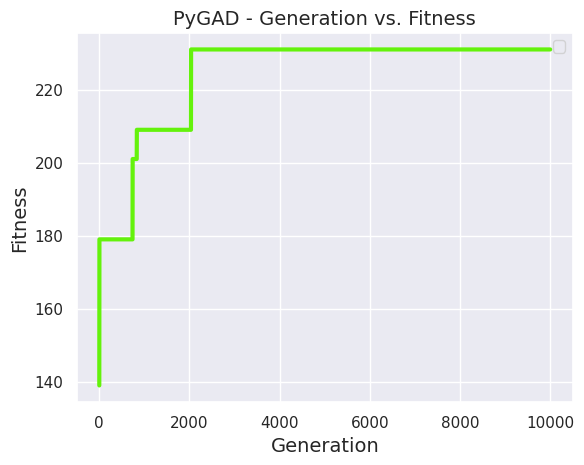

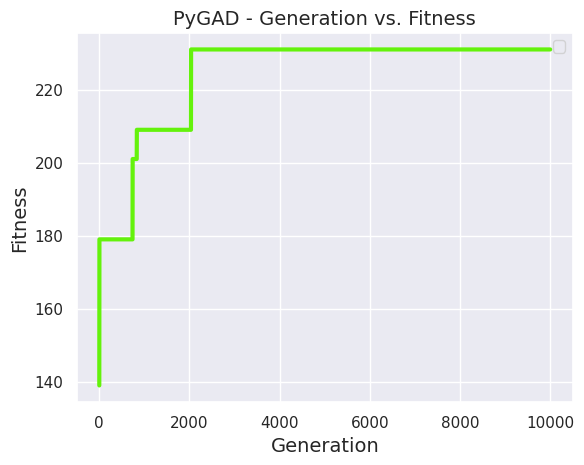

In [10]:
ga_instance.plot_fitness()

In [11]:
solution, solution_fitness, solution_idx = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)
print(f'Solution: {solution}')
print(f'Fitness value of the best solution = {solution_fitness}')

Solution: [0 0 0 0 0 3 0 2 0 3 0 0 0 1 0 0 0 3 3 1]
Fitness value of the best solution = 231


In [12]:
solution_layout = generator.generate_layout("Best solution, 2_000 generations", solution)
print(f'Layout: {solution_layout}')
solution_grid = generator.map_layout_to_grid()
solution_grid.calculate_score()
solution_grid.draw_layout()


Layout: Best solution, 2_000 generations

 # # # # # # # # # # # # # # # #
 # + + + + # + + + + # + + + + #
 # + A A + # + A A + # + A A + #
 # + A A + # + A A + # + A A + #
 # + + + + # + + + + # + + + + #
 # # # # # # # # # # # # # # # #
 # + + + + # + + + + # D D # + #
 # + A A + # + A A + # D D # + #
 # + A A + # + A A + # # # # + #
 # + + + + # + + + + # + + + + #
 # # # # # # # # # # # # # # # #
 # + + + + # + + + + #          
 # + A A + # + A A + #          
 # + A A + # + A A + #          
 # + + + + # + + + + #          
 # # # # # # # # # # #          

Layout area: 231
Maximum area: 256 
Width: 16 
Height: 16

Score: 231

--------------------------------------------------
